## Train, tune, and deploy a custom ML model using Ceramic Tiles Surface Defects Classifier Algorithm from AWS Marketplace 


Image analytics-based solution to classify salient surface defects in Ceramic Tiles.



This sample notebook shows you how to train a custom ML model using Ceramic Tiles Surface Defects Classifier from AWS Marketplace.

> **Note**: This is a reference notebook and it cannot run unless you make changes suggested in the notebook.

#### Pre-requisites:
1. **Note**: This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to For Seller to update: Ceramic Tiles Surface Defects Classifier. 

#### Contents:
1. [Subscribe to the algorithm](#1.-Subscribe-to-the-algorithm)
1. [Prepare dataset](#2.-Prepare-dataset)
	1. [Dataset format expected by the algorithm](#A.-Dataset-format-expected-by-the-algorithm)
	1. [Configure and visualize train and test dataset](#B.-Configure-and-visualize-train-and-test-dataset)
	1. [Upload datasets to Amazon S3](#C.-Upload-datasets-to-Amazon-S3)
1. [Train a machine learning model](#3:-Train-a-machine-learning-model)
	1. [Set up environment](#3.1-Set-up-environment)
	1. [Train a model](#3.2-Train-a-model)
1. [Deploy model and verify results](#4:-Deploy-model-and-verify-results)
    1. [Deploy trained model](#A.-Deploy-trained-model)
    1. [Create input payload](#B.-Create-input-payload)
    1. [Perform real-time inference](#C.-Perform-real-time-inference)
    1. [Visualize output](#D.-Visualize-output)
    1. [Calculate relevant metrics](#E.-Calculate-relevant-metrics)
    1. [Delete the endpoint](#F.-Delete-the-endpoint)
1. [Tune your model! (optional)](#5:-Tune-your-model!-(optional))
	1. [Tuning Guidelines](#A.-Tuning-Guidelines)
	1. [Define Tuning configuration](#B.-Define-Tuning-configuration)
	1. [Run a model tuning job](#C.-Run-a-model-tuning-job)
1. [Perform Batch inference](#6.-Perform-Batch-inference)
1. [Clean-up](#7.-Clean-up)
	1. [Delete the model](#A.-Delete-the-model)
	1. [Unsubscribe to the listing (optional)](#B.-Unsubscribe-to-the-listing-(optional))


#### Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

### 1. Subscribe to the algorithm

To subscribe to the algorithm:
1. Open the algorithm listing page Ceramic Tiles Surface Defects Classifier.
1. On the AWS Marketplace listing,  click on **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn**. This is the algorithm ARN that you need to specify while training a custom ML model. Copy the ARN corresponding to your region and specify the same in the following cell.

In [1]:
algo_arn = 'arn:aws:sagemaker:us-east-2:786796469737:algorithm/ceramic-tiles-defect-detection'

### 2. Prepare dataset

In [2]:
import base64
import json 
import uuid
import sagemaker as sage
from sagemaker import get_execution_role
from urllib.parse import urlparse
import urllib.request
import boto3
from zipfile import ZipFile
from PIL import Image
import io
import pandas as pd

#### A. Dataset format expected by the algorithm

The training input should be a ZIP file of images. It must have images classified into separate folders based on the respective defect types as explained in the Sample Input document.
Each input image must adhere to the minimum size limits: Height 200 px, Width 200 px.
Images must be in PNG or JPG formats.
For optimal results, images must have minimal background noise.
The hyperparameter details (max_try, no_epochs) must be provided in the Jupyter notebook.


#### B. Configure and visualize train dataset

In [3]:
training_dataset='Training Inputs/training/data.zip'

In [4]:
image_zip = ZipFile(training_dataset)

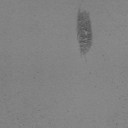

In [5]:
Image.open(io.BytesIO(image_zip.read(image_zip.namelist()[0])))

#### C. Upload datasets to Amazon S3

In [6]:
sagemaker_session = sage.Session()
bucket=sagemaker_session.default_bucket()

In [8]:
# training input location
common_prefix = "ceramic-tiles-defect"
training_input_prefix = common_prefix + "/training-input-data"
TRAINING_WORKDIR = "Training Inputs/training"
training_input = sagemaker_session.upload_data(TRAINING_WORKDIR, key_prefix=training_input_prefix)
print("Training input uploaded to " + training_input)

Training input uploaded to s3://sagemaker-us-east-2-786796469737/ceramic-tiles-defect/training-input-data


## 3: Train a machine learning model

Now that dataset is available in an accessible Amazon S3 bucket, we are ready to train a machine learning model. 

### 3.1 Set up environment

In [9]:
role = get_execution_role()

In [10]:
output_location = 's3://{}/ceramic_tiles_defect/{}'.format(bucket, 'output')

### 3.2 Train a model

Values for two hyperparameters must be provided. \"no_epochs\" specifies the number of epochs to be run. \"max_try\" specifies the maximum number of models to be tried. The search may finish before reaching this maximum number.

In [11]:
#Define hyperparameters
hyperparameters={"no_epochs":1, "max_try":1}

For information on creating an `Estimator` object, see [documentation](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html)

In [ ]:
#Create an estimator object for running a training job
estimator = sage.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    base_job_name="ceramic-tiles-defect-training",
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m5.large',
    input_mode="File",
    output_path=output_location,
    sagemaker_session=sagemaker_session,
    hyperparameters=hyperparameters,
    instance_count=1,
    instance_type='ml.m5.large'
)
#Run the training job.
estimator.fit({"training": training_input})

See this [blog-post](https://aws.amazon.com/blogs/machine-learning/easily-monitor-and-visualize-metrics-while-training-models-on-amazon-sagemaker/) for more information how to visualize metrics during the process. You can also open the training job from [Amazon SageMaker console](https://console.aws.amazon.com/sagemaker/home?#/jobs/) and monitor the metrics/logs in **Monitor** section.

### 4: Deploy model and verify results

Now you can deploy the model for performing real-time inference.

In [13]:
model_name='ceramic-tiles-defect'

content_type='application/zip'

real_time_inference_instance_type='ml.m5.large'
batch_transform_inference_instance_type='ml.m5.large'

#### A. Deploy trained model

In [14]:
from sagemaker.predictor import csv_serializer
predictor = estimator.deploy(1, real_time_inference_instance_type)

..........
----!

Once endpoint is created, you can perform real-time inference.

#### B. Create input payload

In [15]:
file_name = '"Model Input"/inference.zip'

#### C. Perform real-time inference

In [16]:
output_file_name = '"Model Output"/output.csv'

In [17]:
!aws sagemaker-runtime invoke-endpoint \
    --endpoint-name $predictor.endpoint_name \
    --body fileb://$file_name \
    --content-type $content_type \
    --region $sagemaker_session.boto_region_name \
    $output_file_name

{
    "ContentType": "text/csv; charset=utf-8",
    "InvokedProductionVariant": "AllTraffic"
}


#### D. Visualize output

In [18]:
#pd.read_csv("Model Output/output.csv")

#### F. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. you can terminate the same to avoid being charged.

In [19]:
predictor.delete_endpoint(delete_endpoint_config=True)

Since this is an experiment, you do not need to run a hyperparameter tuning job. However, if you would like to see how to tune a model trained using a third-party algorithm with Amazon SageMaker's hyperparameter tuning functionality, you can run the optional tuning step.

### 5. Perform Batch inference

In this section, you will perform batch inference using multiple input payloads together.

In [20]:
#upload the batch-transform job input files to S3
transform_input_folder = "Model Input/inference.zip"
transform_input = sagemaker_session.upload_data(transform_input_folder, key_prefix=model_name) 
print("Transform input uploaded to " + transform_input)

Transform input uploaded to s3://sagemaker-us-east-2-786796469737/ceramic-tiles-defect/inference.zip


In [ ]:
#Run the batch-transform job
transformer = estimator.transformer(1, batch_transform_inference_instance_type)
transformer.transform(transform_input, content_type=content_type)
transformer.wait()

In [22]:
#output is available on following path
transformer.output_path

's3://sagemaker-us-east-2-786796469737/ceramic-tiles-defect-training-2021-11-26-03-56-44-136'

### 6. Clean-up

#### A. Delete the model

In [23]:
transformer.delete_model()

#### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the algorithm, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

